# Exploratory Data Analysis

In [1]:
#Libraries
from collections import Counter
import nltk
import numpy as np
import pandas as pd
import gensim
from gensim import corpora, models, similarities
from gensim.models import word2vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
import seaborn as sns
from functions.Capstone_functions import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
#from nltk import bigrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import datetime as dt
import scipy
#from textblob import TextBlob
%matplotlib inline
#%matplotlib notebook

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamaalsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Details

In [2]:
#pip install pandas-profiling[notebook]

In [3]:
#Utilizing Pandas Profile to summarize Data
#import pandas_profiling
Master_tweet_df =  pd.read_csv('data/data_8_08.csv')
#profile = Master_tweet_df.profile_report(title='Pandas Profiling Report')
#profile.to_file(output_file="data/fifa_pandas_profiling.html")
#profile.to_notebook_iframe()

In [4]:
#Converting date column to datetime from model ready integer format
Master_tweet_df['date'] = pd.to_datetime(Master_tweet_df['date'])
Master_tweet_df['date'].head()

0   2020-02-02
1   2020-02-02
2   2020-02-03
3   2020-02-03
4   2020-02-14
Name: date, dtype: datetime64[ns]

## Info on dataset

In [5]:
# Understand datatypes present and whether there are any null values
Master_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24681 entries, 0 to 24680
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       24681 non-null  int64         
 1   date             24681 non-null  datetime64[ns]
 2   username         24681 non-null  object        
 3   tweet            24681 non-null  object        
 4   replies_count    24681 non-null  int64         
 5   retweets_count   24681 non-null  int64         
 6   likes_count      24681 non-null  int64         
 7   video            24681 non-null  int64         
 8   geo              0 non-null      float64       
 9   positive         24681 non-null  int64         
 10  death            24677 non-null  float64       
 11  word_count       24681 non-null  int64         
 12  avg_word_length  24681 non-null  float64       
 13  stopwords_count  24681 non-null  int64         
 14  char_count       24681 non-null  int64

In [6]:
#Distribution of Target Values
Master_tweet = pickle.load(open('pickles/Master_Tweet_datasetfull.pickle','rb'))
#sns.countplot(x='Target',data=Master_tweet)

## Word2Vec Model Creation

Word2Vec allows for computer systems to not only understand the meaning of words, but allows for contextual understanding. This is useful 
for this analysis because it will allow the computer to understand which words have similar meaning to one another.

In [7]:
#Getting Tokenized list from pickle

tok_corp_8_8 = pickle.load(open('pickles/tok_corp_8_8.pickle','rb'))

In [8]:
#Word2Vec model creation
#To prevent visualization from looking like a ball, each word in the Word2Vec vocabulary must show atleast 200 time
model = gensim.models.Word2Vec(tok_corp_8_8,min_count=200,size= 100,workers=4, window =5, sg = 1)

In [9]:
#Word2Vec Vocabulary
tweet_vocab = model.wv.vocab
words = len(tweet_vocab)
widget_input = list(tweet_vocab)
print(f'There are {words} words in the Word2Vec vocabulary.')

There are 235 words in the Word2Vec vocabulary.


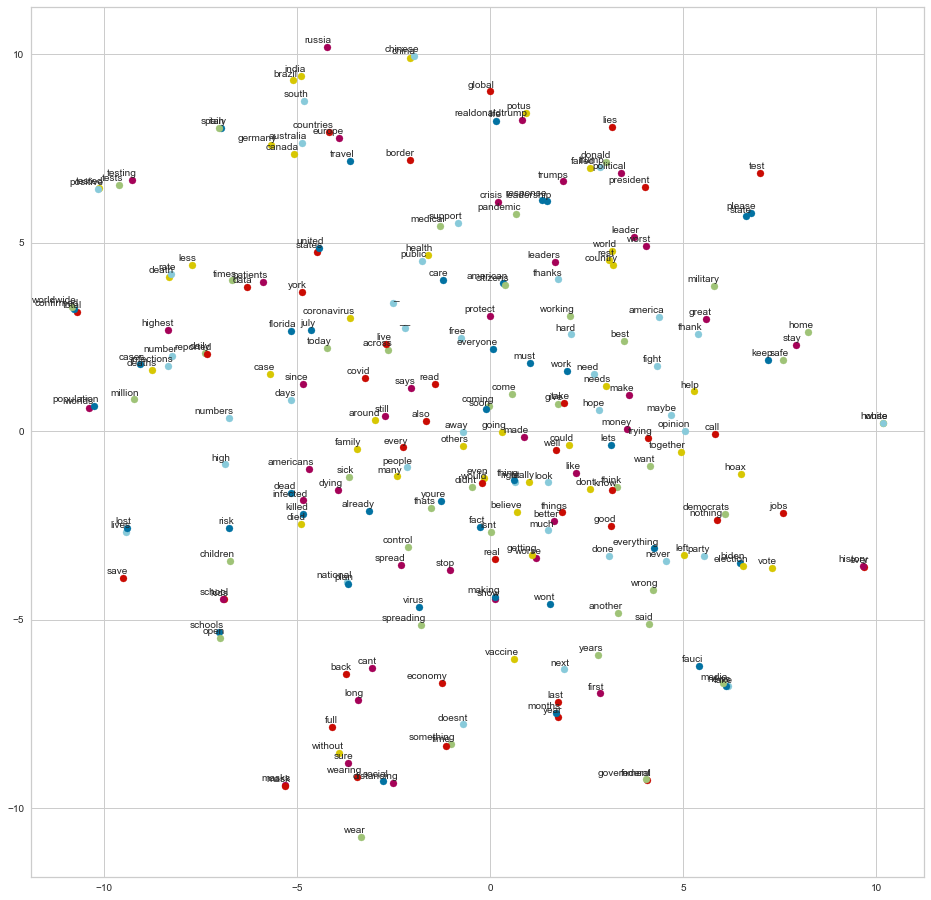

In [10]:
#Plot to show how Word2Vec enables computers to better understand meaning of words in context
tsne_plot(model)

Expanding on the visual above, the below interactive visual allows you to select each word in the vocabulary to see which words are most similar to it. Again, this visual shows how the Word2Vec model empowers the computer to not only understand language, but develop a much higher form of understanding through contextual meanings.

In [11]:
#closest word graph
interact(display_closestwords_tsnescatterplot,model=fixed(model),word=widget_input,size=fixed(100))

interactive(children=(Dropdown(description='word', options=('please', 'give', 'covid', 'spread', 'country', 't…

<function functions.Capstone_functions.display_closestwords_tsnescatterplot(model, word, size)>

## Top 50 Tokens In Corpus

Since tokens represent each word preent in the tweets, the below analysis and visual will provide us with a quick and easy way to view the top 50 words present in the dataset

In [12]:
Master_tweet.columns

Index(['date', 'username', 'tweet', 'replies_count', 'retweets_count',
       'likes_count', 'video', 'geo', 'positive', 'death', 'word_count',
       'avg_word_length', 'stopwords_count', 'char_count', 'stopwords',
       'clean_text', 'Sentiment', 'Poll', 'Start Date', 'End Date', 'Sample',
       'MoE', 'Biden (D)', 'Trump (R)', 'Spread', 'Topic', 'Target',
       'spread_number', 'Target_number'],
      dtype='object')

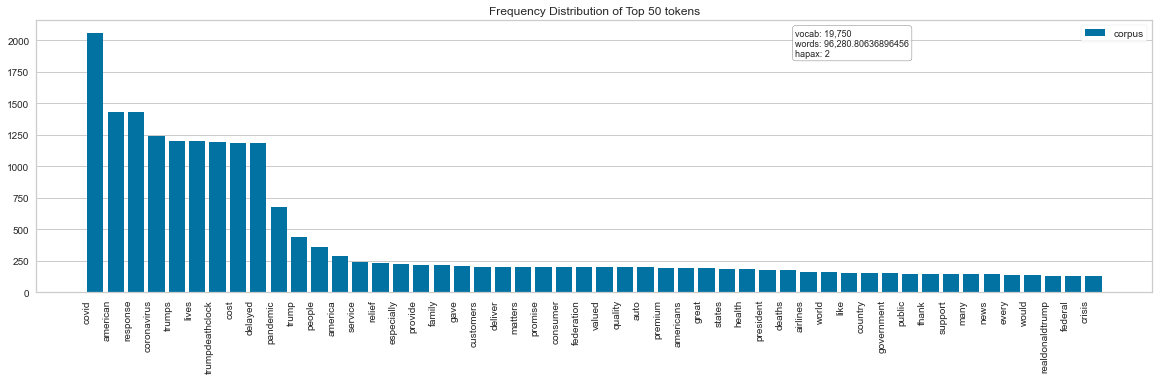

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [13]:
#top tokens
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer

clean_tweet = Master_tweet['clean_text']

fig= plt.figure(figsize=(20,5))
#plt.xticks(rotation=5)

vectorizer = TfidfVectorizer()
docs = vectorizer.fit_transform(clean_tweet)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

## Topic Modeling with Latent Dirichlet Allocation

As a reminder,LDA is an unsupervised machine-learning model that takes documents as input and finds topics as output. Further,as detailed on Towards Data Science, LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

In [14]:
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary

common_dictionary = Dictionary(tok_corp_8_8)
common_corpus = [common_dictionary.doc2bow(text) for text in tok_corp_8_8]

lda = LdaModel(common_corpus, num_topics=20, alpha='auto', eval_every=5)

In [15]:
#Creation of additional items related to the LDA model to allow for creation of visualization

from gensim import corpora, models

list_of_list_of_tokens = list(tok_corp_8_8)
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = 5
tweet_lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))


#saving LDA Model
pickle.dump(tweet_lda_model, open( 'pickles/LDA_modelgensim.pickle', 'wb') )


LDA_model = pickle.load(open('pickles/LDA_modelgensim.pickle','rb'))

In [16]:
num_topics = 5
for i,topic in tweet_lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.018*"great" + 0.018*"trump" + 0.016*"news" + 0.014*"china" + 0.011*"fake" + 0.008*"house" + 0.008*"today" + 0.007*"states" + 0.007*"coronavirus" + 0.007*"white"

1: 0.012*"people" + 0.010*"countries" + 0.008*"china" + 0.008*"mask" + 0.008*"many" + 0.008*"time" + 0.007*"world" + 0.007*"masks" + 0.007*"social" + 0.007*"country"

2: 0.022*"thank" + 0.010*"pandemic" + 0.008*"economic" + 0.008*"medical" + 0.008*"support" + 0.007*"health" + 0.007*"testing" + 0.006*"spread" + 0.006*"president" + 0.005*"approval"

3: 0.040*"cases" + 0.032*"deaths" + 0.014*"death" + 0.013*"world" + 0.011*"coronavirus" + 0.010*"million" + 0.010*"number" + 0.009*"rate" + 0.009*"people" + 0.007*"countries"

4: 0.017*"people" + 0.015*"trump" + 0.013*"great" + 0.011*"president" + 0.009*"like" + 0.007*"dont" + 0.007*"good" + 0.007*"americans" + 0.006*"nothing" + 0.006*"know"



In [17]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=LDA_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Top N-Grams

According to Wikipedia, in the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus.

As an extension to the LDA analysis above, by identifying the top Ngrams, we can also get a sense of what was moving the discussion on Twitter in relationship to peoples response to Covid pandemic.

In [18]:
# Getting ngrams 
# Code influenced by online resources
vectorizer = TfidfVectorizer(ngram_range = (3,3)) 
X1 = vectorizer.fit_transform(clean_tweet)  
features = (vectorizer.get_feature_names()) 
#print("\n\nFeatures : \n", features) 
#print("\n\nX1 : \n", X1.toarray()) 

vectorizer = TfidfVectorizer(ngram_range = (3,3)) 
X2 = vectorizer.fit_transform(clean_tweet) 
scores = (X2.toarray()) 
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0,col] )) 
ranking = pd.DataFrame(data1, columns = ['term','rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords head : \n", words.head(20))
#print("\n\nScores : \n", scores) 



Words head : 
                                      term         rank
26377                 covid response cost  1012.766652
89611              response cost american  1012.293339
30954              delayed covid response  1012.118712
23092                 cost american lives  1011.389392
5090       american lives trumpdeathclock  1010.648712
111153  trumpdeathclock covid coronavirus  1010.239868
61843         lives trumpdeathclock covid  1010.201116
111330               trumps delayed covid  1006.774923
24678             covid coronavirus covid   284.470680
41523             federation america gave   184.554870
83306             promise provide quality   184.554870
113726           valued service customers   184.554870
29057        customers especially matters   184.554870
84732              quality valued service   184.554870
31041             deliver promise provide   184.554870
89685                 response covid auto   184.554870
65103         matters consumer federation   184.

The top three trigrams all speak to how the response to Covid impacted the lives of Americans. Further, we can see that many individuals attribute the poor response to the current US president. Finally, if one were to think of the main idea of trigrams progressing, there is then discussion of how the pandemic has impacted individuals financially.

## Tweet Analysis

In [19]:
#master_tweet_df = pd.read_excel('data/Master_tweet_df.xls')
#master_tweet_df.head()

In [20]:
#performing groupby to smooth out data for graphs
groupby_df_mean = Master_tweet_df.groupby(['date']).mean()
groupby_df_mean.reset_index(level=0, inplace=True)

#groupby_df_mean.columns

The graph below provides an interactive opportunity to view the number of tweets, retweets and replies by date throughout the website.

In [21]:
from datetime import datetime

#Master_tweet_df['date'] = pd.to_datetime(Master_tweet_df['date'], format='%Y%m%d')

In [22]:
import plotly.express as px
groupby_df_count = Master_tweet_df.groupby(['date']).count()
groupby_df_count.reset_index(level=0, inplace=True)
fig = px.bar(groupby_df_count, x="date", y='tweet',color='tweet',title="Tweet Activity")
fig.show()

## Covid Analysis

The below interactive plot allows one to toggle between viewing the amount of Covid cases and Covid deaths in the United States. 

In [23]:
from functions.graphing_functions import *
interact(plotly_line,x=fixed('date'),y=['positive','death'], df=fixed(groupby_df_mean))


interactive(children=(Dropdown(description='y', options=('positive', 'death'), value='positive'), Output()), _…

<function functions.graphing_functions.plotly_line(df, x, y)>

## State Analysis

In [24]:
#state data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
state_data_df = pd.read_csv(url,error_bad_lines=False)
#state_data_df = state_data_df.drop('Unnamed: 0',axis=1)

pickle.dump(state_data_df, open( 'state_data_df.p', "wb" ) )

In [63]:
interact(Plotly_bar,df=fixed(state_data_df),x=fixed('state'),y=['cases','deaths'],title='State Covid Data',color='date')
#Plotly_bar(state_data_df,x='date',y='cases',title="State Cases")


interactive(children=(Dropdown(description='y', options=('cases', 'deaths'), value='cases'), Text(value='State…

<function functions.graphing_functions.Plotly_bar(df, x, y, title, color)>

In [26]:
#loading state dictionary from pickle
us_state_abbrev = pickle.load( open( 'pickles/us_state_abbrev.pickle', "rb" ) )
#Converting state names to abbreviations
state_data_df['abbrev'] = state_data_df['state'].map(us_state_abbrev).fillna(state_data_df['state'])
state_data_df['state'] = state_data_df['abbrev']

In [27]:
#Converting state names to abbreviations & assigning to state column
state_data_df['abbrev'] = state_data_df['state'].map(us_state_abbrev).fillna(state_data_df['state'])
state_data_df['state'] = state_data_df['abbrev']

In [28]:
#Extracting month from each date for US map graph
state_data_df['date'] =  pd.to_datetime(state_data_df['date'])
state_data_df['month'] = state_data_df['date'].dt.month
#state_data_df['abbrev'] = state_data_df['state'].map(state_2)

In [29]:
#Making Pivot Table to organize cases/deaths by month and state of occurence
#table = pd.pivot_table(state_data_df,index=['state','month'],fill_value='N/A')
#table.plot(kind='bar')

In [30]:
#from pivottablejs import pivot_ui
#pivot_ui(state_data_df,outfile_path='state_pivot.html')

## Sentiment Analysis

In [31]:
#Sentiment analysis over time

#Sentiment_Tweet_df = pd.read_csv('data/Tweet_notebook.csv')

#Sentiment_Tweet_df.head()

Feelings_Time = Master_tweet_df[['date','Sentiment','positive','clean_text']]

#Feelings_Time = Sentiment_Tweet_df[['date','Sentiment','Cases_x']]
#Feelings_Time['Date'] = pd.to_datetime(Feelings_Time.Date)
#Feelings_Time.sort('Date')
#Feelings_Time = Feelings_Time.sort_index()

In [32]:
#Histogram of Sentiment
import plotly.express as px

fig = px.histogram(Feelings_Time, x='Sentiment', title='Distribution of Sentiment')
fig.show()

In [33]:
interact(plotly_scatter,y=fixed('Sentiment'),x=['word_count','char_count','likes_count','replies_count','retweets_count'],
         trendline=fixed('OLS'),color=fixed('Sentiment'), df=fixed(Master_tweet_df))
    

interactive(children=(Dropdown(description='x', options=('word_count', 'char_count', 'likes_count', 'replies_c…

<function functions.graphing_functions.plotly_scatter(df, x, y, trendline, color)>

In [34]:
#Feelings_Time.groupby('date').mean()
fig = px.bar(Master_tweet_df, x='date',y='positive', title = 'Sentiment Analysis in Relation to Cases')
fig.show()

In [35]:
fig = px.line(groupby_df_mean,x='date', y="Sentiment", title = 'Sentiment Analysis over Time')
#ax2= px.bar(Master_tweet_df, x='date',y='positive',color='positive', title = 'Sentiment Analysis in Relation to Cases')
fig.show()

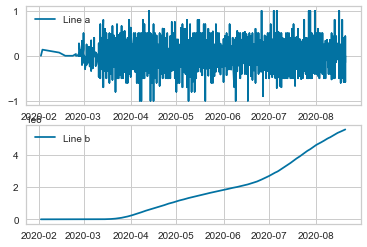

In [36]:
fig, ax = plt.subplots(nrows=2,ncols=1)
plt.subplot(2,1,1)
plt.plot('date','Sentiment',data=Master_tweet_df, label='Line a')
plt.legend()

plt.subplot(2,1,2)
plt.plot('date','positive',data=Master_tweet_df, label = 'Line b')
plt.legend()


## Topic Analysis 

In [37]:
fig = px.histogram(Master_tweet_df, x='Topic', title='Distribution of Topics')
fig.show()

## Deception Detection

In [38]:
#pickling to get the datasets
Trump_Covid_Tweets = pickle.load(open('pickles/Trump_Covid_Tweets.pickle','rb'))
Baseline_Tweets = pickle.load(open('pickles/Baseline_Tweets.pickle','rb'))
Cuomo_Tweets = pickle.load(open('pickles/Cuomo_Covid_Tweets.pickle','rb'))
All_Tweets = pickle.load(open('pickles/All_Covid_Tweets.pickle','rb'))

### Trump Text Feature Analysis

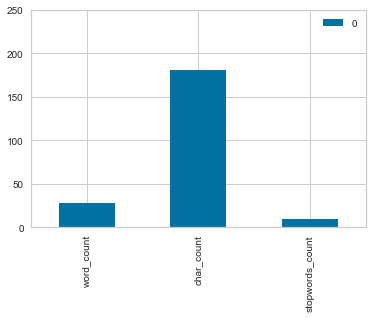

The five most common tags are: [('NNP', 2723), ('JJ', 97), ('CD', 33), ('VBZ', 18), ('NN', 6)]


In [39]:
tweet_text_features(Trump_Covid_Tweets)

### Baseline Text Feature Analysis

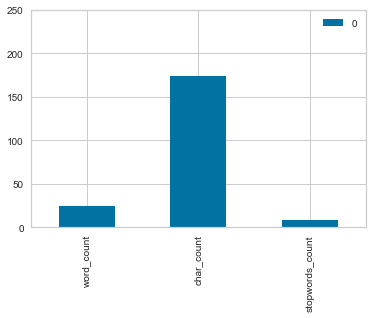

The five most common tags are: [('NNP', 4269), ('JJ', 68), ('CD', 22), ('VBG', 3)]


In [40]:
tweet_text_features(Baseline_Tweets)

### All Tweet Text Feature Analysis

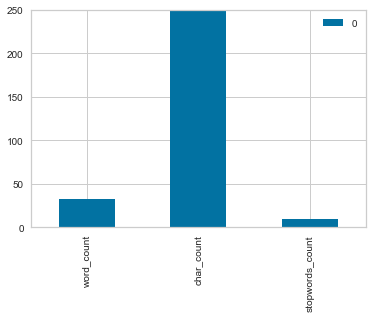

The five most common tags are: [('NNP', 11899), ('JJ', 7921), ('CD', 78), ('NN', 72), ('NNS', 60)]


In [41]:
tweet_text_features(All_Tweets)

### Cuomo Text Feature Analysis

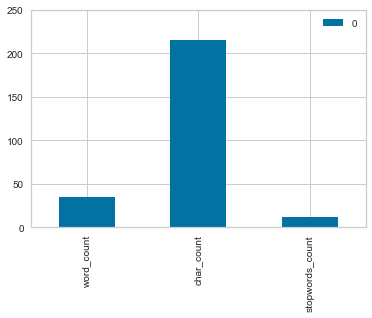

The five most common tags are: [('NNP', 91), ('JJ', 2)]


In [42]:
tweet_text_features(Cuomo_Tweets)

### **Deception Finding**

If one were to assume that tweets by Donald Trump contain the most misinformation based on fact checker reports, tweets with character counts over 175 can be identified as either being deceptive or highly political in nature. The design of this study was to assemble tweets by two leaders that are considered polar opposites - Donald Trump and Andrew Cuomo. Both of these leaders have tweets with character counts over 175. On the otherhand, tweets by non-partisan news agencies have character counts under 175.

[For the purposes of this exercise, tweets that are either deceptive or highly partisan will also have a higher number of filler/stopwords than truthful tweets and false tweets have more verbs than nouns.](https://onlinelibrary.wiley.com/doi/pdf/10.1002/spy2.9)


Text feature breakdown for whole dataset

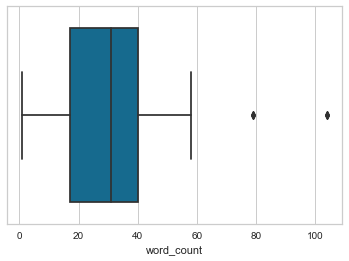

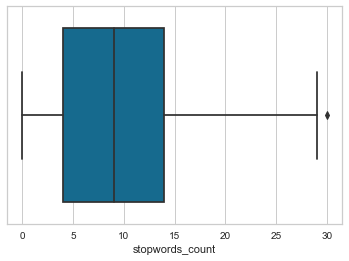

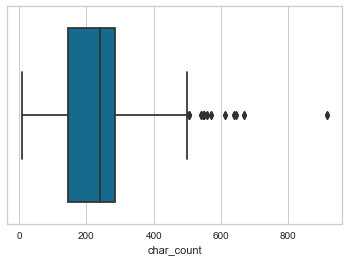

In [43]:
#All Tweet DF

Master_tweet_df = pickle.load(open('pickles/Master_Tweet_datasetfull.pickle','rb'))

#boxplots for text features
text_features = ['word_count','stopwords_count','char_count']

for i in text_features:
    sns.boxplot(x=Master_tweet_df[i])
    plt.show()

Deception breakdown for the dataset

In [44]:
# Assigning Deception to DataFrame

Master_tweet_df['Deception'] = np.where(Master_tweet_df['stopwords_count'] > 10 ,'Possible Deception',
                                       np.where(Master_tweet_df['word_count'] >40, 'Possible Deception','Unlikely Deception'))



<AxesSubplot:xlabel='Deception', ylabel='count'>

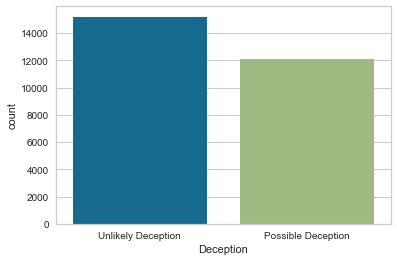

In [45]:
#sns.displot(penguins, x="flipper_length_mm")
sns.countplot(data = Master_tweet_df, x='Deception')

In [66]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(Master_tweet_df['Deception'])
Master_tweet_df['Deception_coded'] = le.transform(Master_tweet_df['Deception'])

<AxesSubplot:xlabel='date', ylabel='Deception_coded'>

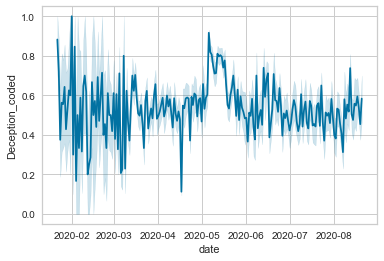

In [67]:
sns.lineplot(x='date',y='Deception_coded',data=Master_tweet_df)

Montly Positive Case breakdown

In [47]:
Master_tweet_df.date = pd.to_datetime(Master_tweet_df.date)

Text(0.5, 0, 'month')

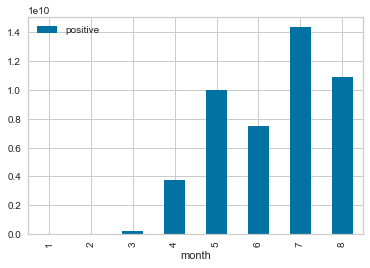

In [48]:
Master_tweet_df[['date','positive']].groupby(Master_tweet_df['date'].dt.month).sum().plot(kind='bar')
plt.xlabel('month')

Monthly Deception breakdown

In [46]:
#making categorical variables 
Master_tweet_df["Deception_codes"] = np.where(Master_tweet_df["Deception"].str.contains("Poss"), 1, 0)

Text(0.5, 0, 'month')

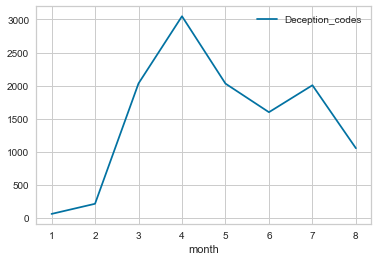

In [49]:
Master_tweet_df[['date','Deception_codes']].groupby(Master_tweet_df['date'].dt.month).sum().plot()
plt.xlabel('month')

Pearson correlation coefficient between Deception and Positive cases

In [50]:
x = Master_tweet_df['Deception_codes']
y = Master_tweet_df['positive']

scipy.stats.pearsonr(x,y)

(0.021333203396992285, 0.00042763391406778616)

## Poll Analysis

Representation of responses between the two different classes

<AxesSubplot:xlabel='Target', ylabel='count'>

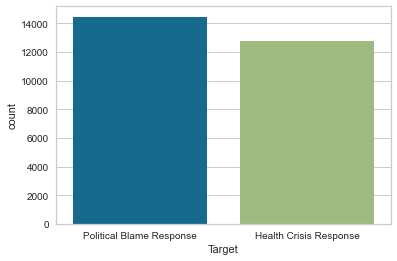

In [53]:
sns.countplot(data=Master_tweet_df,x='Target')

Monthly summary of political blame responses

In [54]:
Master_tweet_df.date = pd.to_datetime(Master_tweet_df.date)

Text(0.5, 0, 'month')

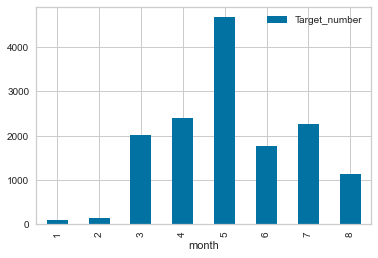

In [61]:
Master_tweet_df["Target_number"] = np.where(Master_tweet_df["Target"].str.contains("Pol"), 1, 0)
Master_tweet_df[['date','Target_number']].groupby(Master_tweet_df['date'].dt.month).sum().plot(kind='bar')
plt.xlabel('month')

Monthly breakdown of spread figures

Text(0.5, 0, 'month')

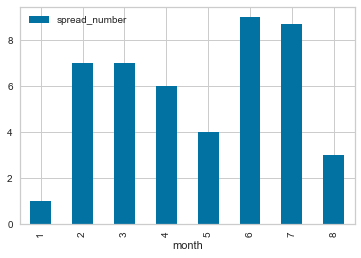

In [56]:
Master_tweet_df[['date','spread_number']].groupby(Master_tweet_df['date'].dt.month).median().plot(kind='bar')
plt.xlabel('month')